# **Dependancies**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/btc_data')

# **Loading Data**

In [ ]:
import pandas as pd

# Đường dẫn đến file btc_data.csv
file_path = '/content/drive/My Drive/Colab Notebooks/btc_data/BTC_Data_2014-2022.csv'

# Đọc file CSV
data = pd.read_csv(file_path)


# Hiển thị 10 dòng đầu tiên
data.head(10)


,Date,priceUSD,size,sentbyaddress,transactions,mining_profitability,sentinusd,transactionfees,median_transaction_fee,confirmationtime,marketcap,transactionvalue,mediantransactionvalue,tweets,google_trends,fee_to_reward,activeaddresses,top100cap
0,2014/04/09,447.110,243742.0,122401,64992,38.678,239212041.0,0.1390,0.0447,8.944,5587996110,4115.0,100.420,8193,11.193,0.502,179274,19.211
1,2014/04/10,407.703,254334.0,124298,67872,31.917,310367120.0,0.0864,0.0408,9.290,5020359905,4876.0,120.946,15039,13.854,0.371,182996,19.166
2,2014/04/11,403.328,223656.0,117926,65563,36.814,292756343.0,0.0858,0.0403,8.521,5068919648,4819.0,108.481,14907,12.997,0.330,169622,19.141
3,2014/04/12,425.310,169964.0,87828,47579,34.498,157264741.0,0.0811,0.0425,8.944,5329088351,3574.0,84.408,7582,9.229,0.226,132283,19.145
4,2014/04/13,415.876,162260.0,94828,50981,34.141,154756367.0,0.0840,0.0416,7.701,5150414718,3332.0,69.681,10674,10.385,0.221,172708,19.131
5,2014/04/14,445.898,216048.0,127969,70026,37.973,253143718.0,0.0977,0.0446,7.461,5628122040,3990.0,115.249,13266,10.754,0.318,183291,19.146
6,2014/04/15,487.666,241539.0,123107,72627,38.650,293892234.0,0.1110,0.0488,7.912,6170470953,4479.0,123.089,14835,11.053,0.362,199054,19.124
7,2014/04/16,517.354,270984.0,114312,68435,40.201,389249585.0,0.1080,0.0517,9.057,6496569317,6046.0,129.799,15790,12.189,0.359,185075,19.146
8,2014/04/17,505.461,223631.0,102596,65021,40.706,385378002.0,0.1170,0.0505,8.521,6281237538,6384.0,102.416,15215,11.471,0.355,157751,19.092
9,2014/04/18,485.296,205478.0,100633,56836,35.818,360602878.0,0.1040,0.0485,9.000,5972292967,6461.0,107.713,14028,9.946,0.304,149452,19.054


# **Model Architecture + Training**

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Định nghĩa mô hình DiffusionProcess: tạo lịch trình beta và hàm thêm nhiễu
class DiffusionProcess:
    def __init__(self, beta_start=0.0, beta_end=1.0, diff_steps=1000, device='cpu'):
        # Lịch trình beta tuyến tính từ beta_start đến beta_end
        self.T = diff_steps
        self.beta = torch.linspace(beta_start, beta_end, diff_steps, device=device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)  # tích lũy của alpha

    def q_sample(self, x0, t):
        """
        Thêm nhiễu Gaussian vào x0 theo bước t:
        x_t = sqrt(alpha_bar[t]) * x0 + sqrt(1 - alpha_bar[t]) * noise
        """
        # x0: tensor (batch,1), t: tensor (batch,) hoặc int
        if isinstance(t, int):
            t = torch.full((x0.shape[0],), t, dtype=torch.long, device=x0.device)
        alpha_bar_t = self.alpha_bar[t].view(-1, 1)  # lấy alpha_bar tại bước t
        noise = torch.randn_like(x0)  # nhiễu chuẩn
        xt = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1.0 - alpha_bar_t) * noise
        return xt

# Định nghĩa mô hình DiffusionVAE: encoder-decoder với latent và thông số thời gian
class DiffusionVAE(nn.Module):
    def __init__(self, feature_dim, latent_dim=16):
        super(DiffusionVAE, self).__init__()
        self.feature_dim = feature_dim
        # Kích thước mạng
        hidden_dim = 64
        # Encoder: đầu vào gồm features + giá có nhiễu + bước t
        enc_input_dim = feature_dim + 2  # +1 cho giá có nhiễu, +1 cho t
        self.encoder = nn.Sequential(
            nn.Linear(enc_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder: đầu vào gồm latent + features + bước t
        dec_input_dim = latent_dim + feature_dim + 1  # +1 cho t
        self.decoder = nn.Sequential(
            nn.Linear(dec_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def reparameterize(self, mu, logvar):
        # Kỹ thuật reparameterization trong VAE
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, features, x_t, t):
        """
        features: tensor (batch, feature_dim)
        x_t: tensor (batch,1) giá có nhiễu
        t: tensor (batch,1) bước thời gian (đã chia tỉ lệ)
        """
        # Kết hợp features, t và x_t để đưa vào encoder
        inputs = torch.cat([features, t, x_t], dim=1)
        h = self.encoder(inputs)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        # Decoder: kết hợp latent z với features và t để dự đoán giá
        dec_inputs = torch.cat([z, features, t], dim=1)
        output = self.decoder(dec_inputs)
        return output, mu, logvar

# Chọn thiết bị tính toán (GPU nếu có, ngược lại CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Thư mục lưu mô hình tốt nhất
save_dir = '/content/drive/My Drive/Colab Notebooks/btc_data/Model_Diffusion-VAE'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'best_diffusion_vae.pt')

# Đọc dữ liệu từ file CSV
df = data.copy()
# Chuyển cột Date sang datetime và sắp xếp theo thời gian
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# Chia dữ liệu 90% train, 10% test (theo thứ tự thời gian)
n = len(df)
n_train = int(n * 0.9)
train_df = df.iloc[:n_train].reset_index(drop=True)
test_df = df.iloc[n_train:].reset_index(drop=True)

# Các cột số (features và target)
numeric_cols = ['priceUSD', 'size', 'sentbyaddress', 'transactions',
                'mining_profitability', 'sentinusd', 'transactionfees',
                'median_transaction_fee', 'confirmationtime',
                'marketcap', 'transactionvalue', 'mediantransactionvalue',
                'tweets', 'google_trends', 'fee_to_reward',
                'activeaddresses', 'top100cap']
feature_cols = [col for col in numeric_cols if col != 'priceUSD']
target_col = 'priceUSD'

# Chuẩn hóa MinMax cho các cột số (fit trên tập train)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
train_X = scaler_X.fit_transform(train_df[feature_cols].values)
train_y = scaler_y.fit_transform(train_df[[target_col]].values)
test_X = scaler_X.transform(test_df[feature_cols].values)
test_y = scaler_y.transform(test_df[[target_col]].values)

# Chuyển thành tensor và tạo DataLoader
X_train_tensor = torch.tensor(train_X, dtype=torch.float32)
y_train_tensor = torch.tensor(train_y, dtype=torch.float32)
X_test_tensor = torch.tensor(test_X, dtype=torch.float32)
y_test_tensor = torch.tensor(test_y, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Khởi tạo mô hình và DiffusionProcess
feature_dim = train_X.shape[1]
latent_dim = 16
model = DiffusionVAE(feature_dim=feature_dim, latent_dim=latent_dim).to(device)
diffusion = DiffusionProcess(beta_start=0.0, beta_end=1.0, diff_steps=1000, device=device)

# Định nghĩa hàm mất mát và tối ưu
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)

# Huấn luyện mô hình (2000 epochs)
n_epochs = 2000
best_loss = float('inf')
for epoch in range(1, n_epochs + 1):
    model.train()
    train_losses = []
    for features, target in train_loader:
        features = features.to(device)
        target = target.to(device)
        # Chọn bước thời gian ngẫu nhiên cho mỗi mẫu trong batch
        batch_size_cur = features.size(0)
        t = torch.randint(0, diffusion.T, (batch_size_cur,), device=device)
        # Thêm nhiễu vào giá (xác suất t)
        x_t = diffusion.q_sample(target, t)  # tensor (batch,1)
        t_norm = (t.float() / diffusion.T).unsqueeze(1).to(device)  # chuẩn hóa bước t
        optimizer.zero_grad()
        # Dự đoán
        output, mu, logvar = model(features, x_t, t_norm)
        # Lỗi tái tạo (MSE) và KL-divergence
        recon_loss = criterion(output, target)
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    epoch_loss = np.mean(train_losses)
    print(f'Epoch {epoch}, Loss: {epoch_loss}')
    # Lưu mô hình khi cải thiện loss
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), save_path)

# Tải mô hình có loss nhỏ nhất
model.load_state_dict(torch.load(save_path))
model.eval()

# Dự đoán trên tập test bằng quá trình diffusion ngược
preds = []
actuals = []
with torch.no_grad():
    for features, target in test_loader:
        features = features.to(device)
        target = target.to(device)
        # Bắt đầu từ x_T có nhiều nhiễu (t = T-1)
        x = diffusion.q_sample(target, diffusion.T - 1)
        # Khuếch tán ngược từ t=T-1 về t=1
        for t_step in range(diffusion.T - 1, 0, -1):
            t_tensor = torch.full((features.size(0), 1), t_step, device=device, dtype=torch.long)
            t_norm = t_tensor.float() / diffusion.T
            pred_x0, _, _ = model(features, x, t_norm)  # dự đoán giá gốc
            if t_step > 1:
                alpha_bar_prev = diffusion.alpha_bar[t_step - 1]
                noise = torch.randn_like(x)
                x = torch.sqrt(alpha_bar_prev) * pred_x0 + torch.sqrt(1 - alpha_bar_prev) * noise
        # pred_x0 chứa giá trị dự đoán cuối cùng (t=1)
        preds.extend(pred_x0.cpu().numpy().flatten().tolist())
        actuals.extend(target.cpu().numpy().flatten().tolist())

# Đưa dự đoán về thang giá gốc
preds = np.array(preds).reshape(-1, 1)
actuals = np.array(actuals).reshape(-1, 1)
preds = scaler_y.inverse_transform(preds).flatten()
actuals = scaler_y.inverse_transform(actuals).flatten()

# Tính các chỉ số MAE, RMSE, R^2
mae = mean_absolute_error(actuals, preds)
rmse = np.sqrt(mean_squared_error(actuals, preds))
r2 = r2_score(actuals, preds)

print("Evaluation Metrics:")
print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R^2: {r2:.6f}")


# Lưu kết quả dự đoán vào file CSV
results_df = pd.DataFrame({
    'Ngày': test_df['Date'],
    'Giá thực tế (USD)': actuals,
    'Giá dự đoán (USD)': preds
})
results_df.to_csv(save_dir + '/predictions.csv', index=False)


Epoch 1, Loss: 0.03991711268511911
Epoch 2, Loss: 0.00853690753897859
Epoch 3, Loss: 0.0031839077852459418
Epoch 4, Loss: 0.002190193118682752
Epoch 5, Loss: 0.0016800686167294367
Epoch 6, Loss: 0.0013852886590434031
Epoch 7, Loss: 0.0011762357184327103
Epoch 8, Loss: 0.0009510085112803305
Epoch 9, Loss: 0.000804494687084419
Epoch 10, Loss: 0.0006727659117637409
Epoch 11, Loss: 0.00064728023393804
Epoch 12, Loss: 0.0004891103164279937
Epoch 13, Loss: 0.0004574928317904576
Epoch 14, Loss: 0.00041340862274713195
Epoch 15, Loss: 0.0003599679579363308
Epoch 16, Loss: 0.0003047623778305327
Epoch 17, Loss: 0.00027480527852377336
Epoch 18, Loss: 0.0002623198222459501
Epoch 19, Loss: 0.00021810238823592146
Epoch 20, Loss: 0.00020871767038544122
Epoch 21, Loss: 0.00018449085392704647
Epoch 22, Loss: 0.00019387744743855568
Epoch 23, Loss: 0.0001599315577348332
Epoch 24, Loss: 0.00012689886085960703
Epoch 25, Loss: 0.00012307089867438965
Epoch 26, Loss: 0.00011543976979737636
Epoch 27, Loss: 0.00

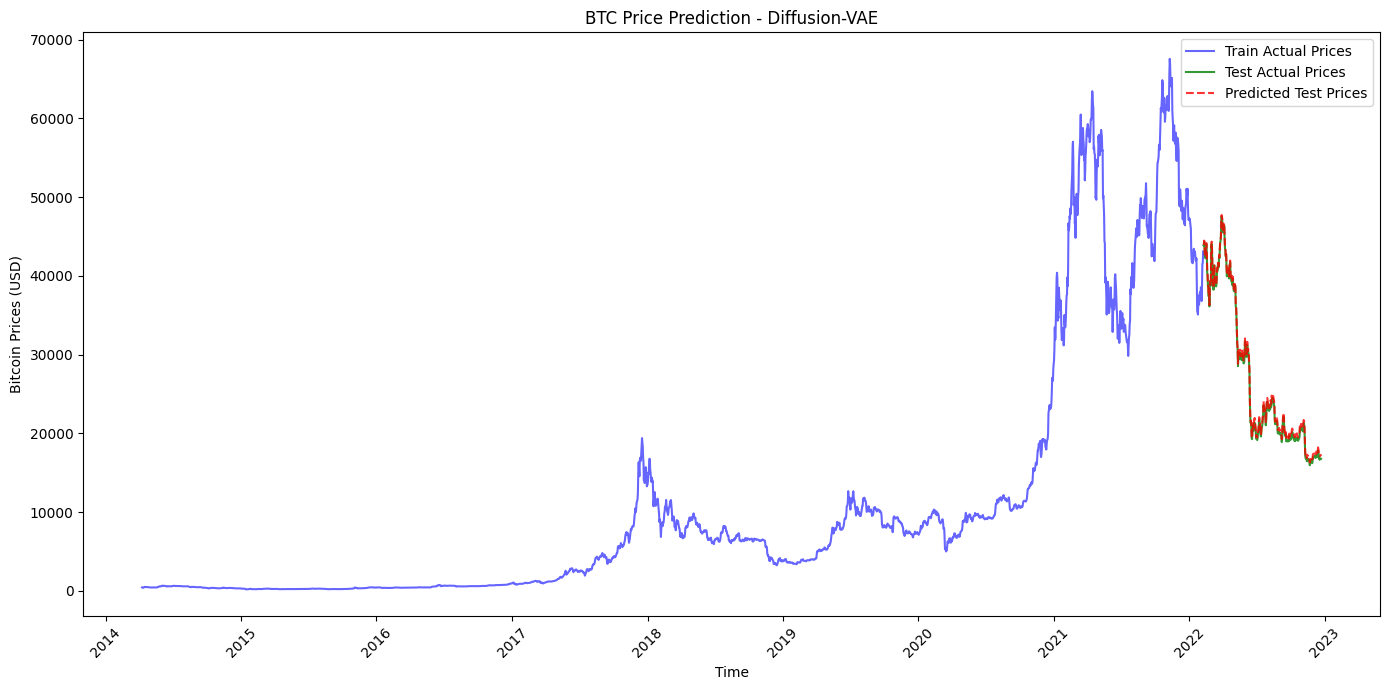

In [ ]:
# Vẽ đồ thị với dữ liệu train, test và dự đoán với trục hoành là thời gian
plt.figure(figsize=(14, 7))

# Dữ liệu huấn luyện
train_dates = train_df['Date']  # Thời gian của dữ liệu huấn luyện
train_prices = scaler_y.inverse_transform(train_y).flatten()  # Giá thực tế của dữ liệu huấn luyện

# Dữ liệu kiểm tra
test_dates = test_df['Date']  # Thời gian của dữ liệu kiểm tra
test_prices = scaler_y.inverse_transform(test_y).flatten()  # Giá thực tế của dữ liệu kiểm tra

# Dự đoán
pred_dates = test_df['Date']  # Thời gian của dữ liệu kiểm tra
pred_prices = preds  # Giá dự đoán từ mô hình

# Vẽ đồ thị
plt.plot(train_dates, train_prices, label='Train Actual Prices', color='blue', linestyle='-', alpha=0.6)
plt.plot(test_dates, test_prices, label='Test Actual Prices', color='green', linestyle='-', alpha=0.8)
plt.plot(pred_dates, pred_prices, label='Predicted Test Prices', color='red', linestyle='--', alpha=0.8)

# Thêm chú thích
plt.xlabel('Time')
plt.ylabel('Bitcoin Prices (USD)')
plt.title('BTC Price Prediction - Diffusion-VAE')
plt.legend()
plt.xticks(rotation=45)  # Xoay các nhãn thời gian nếu cần thiết
plt.tight_layout()  # Điều chỉnh vị trí các nhãn
plt.show()


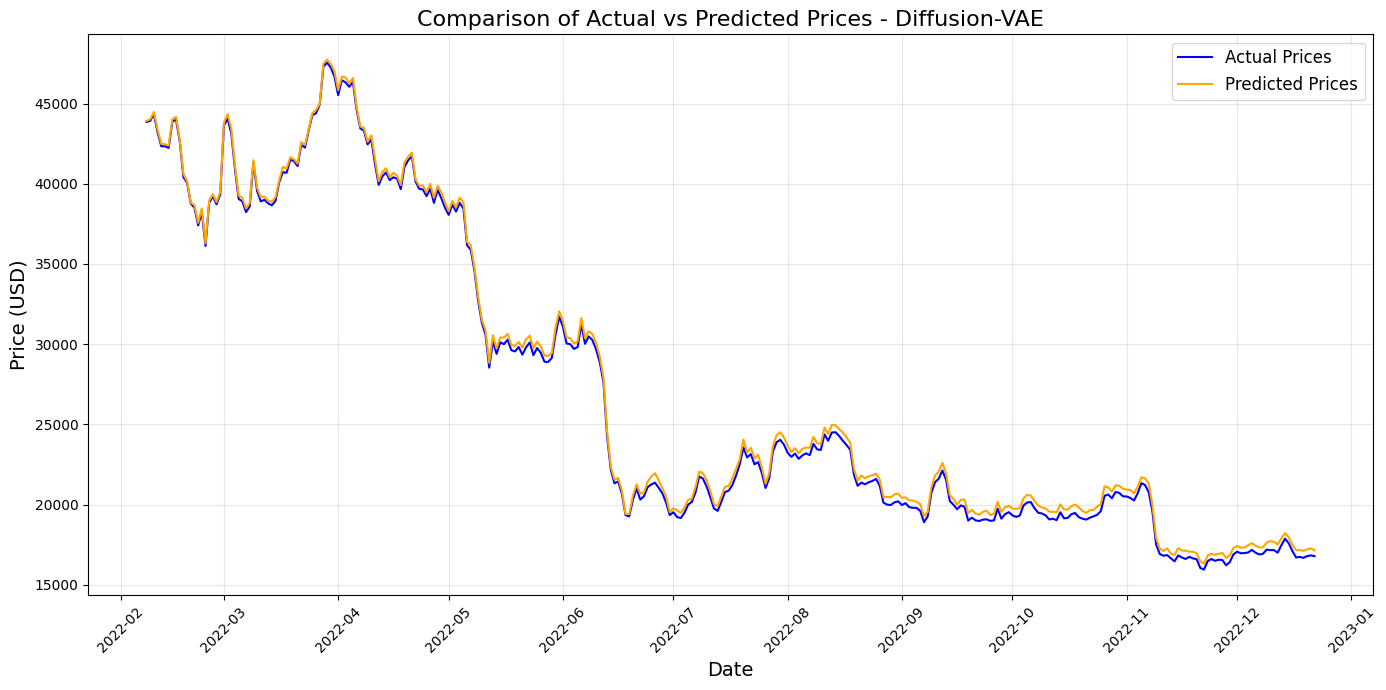

In [ ]:
# Vẽ đồ thị so sánh giá thực tế và giá dự đoán
plt.figure(figsize=(14, 7))

# Lấy ngày từ tập test
test_dates = test_df['Date'].values

plt.plot(test_dates, actuals, label='Actual Prices', color='blue', linestyle='-', linewidth=1.5)
plt.plot(test_dates, preds, label='Predicted Prices', color='orange', linestyle='-', linewidth=1.5)

plt.title('Comparison of Actual vs Predicted Prices - Diffusion-VAE', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
